# Task for Today  

***

## Legendary Pokémon Classification  

Use a FeedForward Neural Network to predict if a given Pokémon is **legendary** or not, based on *Pokémon features*.


<img src="https://wallpapers.com/images/hd/legendary-pokemon-pictures-7yo7x0f1l2b2tu0r.jpg" width="800" height="500" alt="legendaries">

Data available at: https://github.com/Vaeliss/Pokemon_challenge/blob/main/pokemon.csv

Download the `pokemon.csv` file and put it in the file section of Colab.

# Challenge

TAs want to battle!

<img src="https://pokemongohub.net/wp-content/uploads/2023/06/grunts-1.jpg" width="400" height="300" alt="TAs">

Rules of the challenge:

- Gotta catch 'em all! ...But give priority to the legendaries.
- F1-score is usually the measure of choice for imbalanced datasets; however in this case we particularly want to avoid not "catching" legendaries. They're so rare, you might not have any more chances to catch 'em if they flee...
- In ML terms, we give recall more importance than precision for the task (check the whiteboard if you don't know their meaning).
- F2-score (i.e., [F-$\beta$-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html) with $\beta = 2$) is hence used as the main evaluation metric for your model.

if B > 1 recall over precision
else B < 1 precisione over recall

- **TAs achieved a F2-score of 0.80. Can you beat them?!**

# Imports and dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.optim as optim

In [ ]:
_ = torch.manual_seed(42) # for a fair comparison, don't change the seed!

In [ ]:
data = pd.read_csv('pokemon.csv')

In [ ]:
data

,dexnum,name,generation,type1,type2,height,weight,hp,attack,defense,sp_atk,sp_def,speed,total,legendary
0,1025,Pecharunt,9,Poison,Ghost,0.3,0.3,88,88,160,88,88,88,600,1
1,1024,Terapagos,9,Normal,NaN,0.2,6.5,90,65,85,65,85,60,450,1
2,1023,Iron Crown,9,Steel,Psychic,1.6,156.0,90,72,100,122,108,98,590,0
3,1022,Iron Boulder,9,Rock,Psychic,1.5,162.5,90,120,80,68,108,124,590,0
4,1021,Raging Bolt,9,Electric,Dragon,5.2,480.0,125,73,91,137,89,75,590,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,5,Charmeleon,1,Fire,NaN,1.1,19.0,58,64,58,80,65,80,405,0
1021,4,Charmander,1,Fire,NaN,0.6,8.5,39,52,43,60,50,65,309,0
1022,3,Venusaur,1,Grass,Poison,2.0,100.0,80,82,83,100,100,80,525,0
1023,2,Ivysaur,1,Grass,Poison,1.0,13.0,60,62,63,80,80,60,405,0


In [ ]:
data_raw = data.copy() # usually, if memory allows it, it's a good idea to keep a raw version of your data

# Pre-processing / encoding

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dexnum      1025 non-null   int64  
 1   name        1025 non-null   object 
 2   generation  1025 non-null   int64  
 3   type1       1025 non-null   object 
 4   type2       526 non-null    object 
 5   height      1025 non-null   float64
 6   weight      1025 non-null   float64
 7   hp          1025 non-null   int64  
 8   attack      1025 non-null   int64  
 9   defense     1025 non-null   int64  
 10  sp_atk      1025 non-null   int64  
 11  sp_def      1025 non-null   int64  
 12  speed       1025 non-null   int64  
 13  total       1025 non-null   int64  
 14  legendary   1025 non-null   int64  
dtypes: float64(2), int64(10), object(3)
memory usage: 120.2+ KB


In [ ]:
data.isna().sum()

,0
dexnum,0
name,0
generation,0
type1,0
type2,499
height,0
weight,0
hp,0
attack,0
defense,0


In [ ]:
data = data.drop(['dexnum', 'name', 'type2'], axis=1)
# dropping type 2 is actually a debeatable step, it may provide useful information
# data = data.drop(["#", "Name"], axis=1)

In [ ]:
data['legendary'] = data['legendary'].astype(int)
data['generation'] = data['generation'].astype(str)

In [ ]:
data.dtypes

,0
generation,object
type1,object
height,float64
weight,float64
hp,int64
attack,int64
defense,int64
sp_atk,int64
sp_def,int64
speed,int64


Categorical variables are one-hot encoded

In [ ]:
def onehot_encode(df, column, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [ ]:
data = onehot_encode(data, 'type1', 't')
data = onehot_encode(data, 'generation', 'g')

In [ ]:
data.shape

(1025, 37)

In [ ]:
data.head()

,height,weight,hp,attack,defense,sp_atk,sp_def,speed,total,legendary,...,t_Water,g_1,g_2,g_3,g_4,g_5,g_6,g_7,g_8,g_9
0,0.3,0.3,88,88,160,88,88,88,600,1,...,False,False,False,False,False,False,False,False,False,True
1,0.2,6.5,90,65,85,65,85,60,450,1,...,False,False,False,False,False,False,False,False,False,True
2,1.6,156.0,90,72,100,122,108,98,590,0,...,False,False,False,False,False,False,False,False,False,True
3,1.5,162.5,90,120,80,68,108,124,590,0,...,False,False,False,False,False,False,False,False,False,True
4,5.2,480.0,125,73,91,137,89,75,590,0,...,False,False,False,False,False,False,False,False,False,True


## Splitting and Scaling

In [ ]:
data.columns # note that only the first 9 features are continuous now

Index(['height', 'weight', 'hp', 'attack', 'defense', 'sp_atk', 'sp_def',
       'speed', 'total', 'legendary', 't_Bug', 't_Dark', 't_Dragon',
       't_Electric', 't_Fairy', 't_Fighting', 't_Fire', 't_Flying', 't_Ghost',
       't_Grass', 't_Ground', 't_Ice', 't_Normal', 't_Poison', 't_Psychic',
       't_Rock', 't_Steel', 't_Water', 'g_1', 'g_2', 'g_3', 'g_4', 'g_5',
       'g_6', 'g_7', 'g_8', 'g_9'],
      dtype='object')

In [ ]:
y = data['legendary']
X = data.drop('legendary', axis=1)

In [ ]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X.iloc[:,:9])
X = np.concatenate((X_scaled, np.array(X.iloc[:,9:])), axis=1)

In [ ]:
# keep the proportions for the split equal and specify a seed of 42, we want a fair fight!
# Note: end split should be 0.60,0.20,0.20 for train,valid,test

train_size = 0.6
valid_size = 0.4
test_size = 0.5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=valid_size, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=test_size, random_state=42)

# Model definition

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using {device} device")

Using cpu device


### Define your model :

Choose yourself in the model:
- number of hidden layers
- number of neurons per layer (careful with input = 36 and output = 1, these are not a choice)
- activation functions
- any other possible component among those seen so far in theory.

In [ ]:
import torch.nn.functional as F

class Model(nn.Module):
 def __init__(self, input_size, d_1, d_2, output_size):
  super(Model, self).__init__()
  self.fc1 = nn.Linear(input_size, d_1)
  self.fc2 = nn.Linear(d_1, d_2)
  self.fc3 = nn.Linear(d_2, output_size)

 def forward(self, x):
  x = self.fc1(x)
  x = F.relu(x)
  x = self.fc2(x)
  x = F.relu(x)
  x = self.fc3(x)
  return x

Instantiate your model and print it out

In [ ]:
input_dim = X.shape[1]

In [ ]:
model = Model(input_dim, 18, 9, 1).to(device)
print(model)

Model(
  (fc1): Linear(in_features=36, out_features=18, bias=True)
  (fc2): Linear(in_features=18, out_features=9, bias=True)
  (fc3): Linear(in_features=9, out_features=1, bias=True)
)


### Hyperparameters:

Choose carefully your:
- learning rate (this is usually the most important hyperparameter to get right, but some optimizers are more forgiving than others)
- batch size
- number of epochs.
- other hyperparameters that you might need

In [ ]:
learning_rate = 0.01
batch_size=64
epochs=100

### Loss function and optimizer:

- What's the appropriate loss function for the task? [Remember that is a binary classification problem]

- Decide which optimizer you want to use ([Documentation](https://pytorch.org/docs/stable/optim.html))

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate) # One of the most common

Define your TensorDatasets and DataLoaders; remember to use the appropriate dtype for your tensors.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Convert to NumPy arrays if they are still in Pandas DataFrame/Series format
X_train = X_train.values if hasattr(X_train, 'values') else X_train
X_valid = X_valid.values if hasattr(X_valid, 'values') else X_valid
X_test = X_test.values if hasattr(X_test, 'values') else X_test

y_train = y_train.values if hasattr(y_train, 'values') else y_train
y_valid = y_valid.values if hasattr(y_valid, 'values') else y_valid
y_test = y_test.values if hasattr(y_test, 'values') else y_test

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64)

X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.int64)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size)
validation_loader = DataLoader(valid_dataset, batch_size=len(valid_dataset))
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

In [ ]:
# Keep track of training and validation losses during training

train_loss_list = []
valid_loss_list = []

train_length = len(train_loader)
valid_length = len(validation_loader)

# Training

Implement your training and evaluation (for the validation set) loops

In [ ]:
all_predictions = []
all_targets = []

for epoch in range(epochs):
    for data, target in train_loader:
        # Set the model in training mode
        model.train()
        data, target = data.to(device), target.to(device)
        # You have to flatten the data!
        data = data.reshape(-1,input_dim)
        target = target.unsqueeze(1)
        target = target.float()
        # Set the gradient to 0
        optimizer.zero_grad()
        # Make a prediction
        output = model(data)
        # Compute the loss function
        loss = loss_fn(output, target)
        # Backpropagation
        loss.backward()
        # Update parameters
        optimizer.step()

    train_loss = loss.item()
    train_loss_list.append(train_loss)
    # At the end of every epoch, check the validation loss value
    with torch.no_grad():
        model.eval()
        for data, target in validation_loader: # Just one batch
            data, target = data.to(device), target.to(device)
             # You have to flatten the data!
            data = data.reshape(-1,input_dim)

            # Ensure target has the correct shape for validation: [batch_size, 1]
            target = target.unsqueeze(1)  # Reshape target to [batch_size, 1]
            target = target.float()  # Ensure target is float

            # Make a prediction
            output = model(data)
            # Compute the loss function
            validation_loss = loss_fn(output, target).item()
            print(f"Epoch {epoch + 1}: Train loss: {train_loss}, Validation loss {validation_loss}")
            valid_loss_list.append(validation_loss)

            # Apply sigmoid to get probabilities and then convert to binary predictions
            #predicted_probs = torch.sigmoid(output)  # Apply sigmoid
            #predicted = (predicted_probs > 0.5).float()  # Convert probabilities to binary (0 or 1)

            #all_predictions.append(predicted.cpu().numpy())
            #all_targets.append(target.unsqueeze(1).cpu().numpy())  # Reshape target and move to CPU

# Concatenate all predictions and targets
all_predictions = []
all_targets = []

# Compute the accuracy on the test set
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        # You have to flatten the data!
        data = data.reshape(-1,input_dim)
        outputs = model(data)

        predicted_probs = torch.sigmoid(outputs)

        predicted = (predicted_probs > 0.5).float()

        # Store predictions and true labels for metrics calculation
        all_predictions.extend(predicted.cpu().numpy())  # Add to predictions list
        all_targets.extend(target.cpu().numpy())  # Add to true labels list

        n_samples += target.size(0)
        n_correct += (predicted.view(-1) == target).sum().item()

Epoch 1: Train loss: 0.12616167962551117, Validation loss 0.09548883140087128
Epoch 2: Train loss: 0.1259116381406784, Validation loss 0.09548477828502655
Epoch 3: Train loss: 0.12565067410469055, Validation loss 0.09549213200807571
Epoch 4: Train loss: 0.12540766596794128, Validation loss 0.09549463540315628
Epoch 5: Train loss: 0.12514808773994446, Validation loss 0.09550202637910843
Epoch 6: Train loss: 0.12490411847829819, Validation loss 0.09549292922019958
Epoch 7: Train loss: 0.12465217709541321, Validation loss 0.09549066424369812
Epoch 8: Train loss: 0.12442109733819962, Validation loss 0.09548492729663849
Epoch 9: Train loss: 0.12416334450244904, Validation loss 0.09546301513910294
Epoch 10: Train loss: 0.12390033900737762, Validation loss 0.09544292837381363
Epoch 11: Train loss: 0.1236381009221077, Validation loss 0.09542428702116013
Epoch 12: Train loss: 0.12339039146900177, Validation loss 0.09541326016187668
Epoch 13: Train loss: 0.12314605712890625, Validation loss 0.09

# Results

### Plotting

Plot out the training and validation losses over the epochs

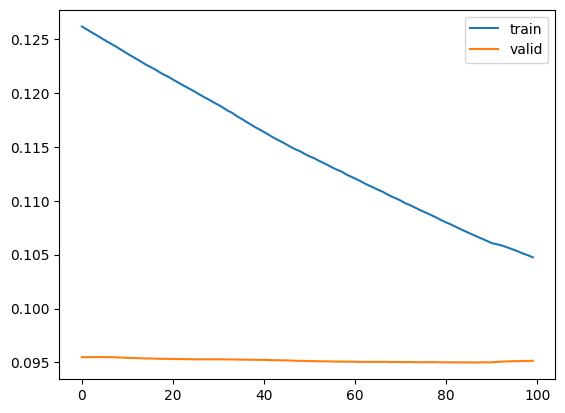

In [ ]:
plt.plot(range(epochs), train_loss_list, label='train')
plt.plot(range(epochs), valid_loss_list, label='valid')
plt.legend(loc="best")
plt.show()

### Metrics

Print out appropriate metrics for the task

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, fbeta_score, classification_report

# Flatten the targets for accuracy score and confusion matrix
#all_targets_flat = all_targets.flatten()
#all_predictions_flat = all_predictions.flatten()

# Compute accuracy
accuracy = accuracy_score(all_targets, all_predictions)
print(f"Accuracy: {accuracy:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(all_targets, all_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Compute F-beta score (with beta=2)
fbeta = fbeta_score(all_targets, all_predictions, beta=2)
print(f"F-beta Score (beta=2): {fbeta:.4f}")

# Print classification report
class_report = classification_report(all_targets, all_predictions)
print("Classification Report:")
print(class_report)

Accuracy: 0.9561
Confusion Matrix:
[[181   4]
 [  5  15]]
F-beta Score (beta=2): 0.7576
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       185
           1       0.79      0.75      0.77        20

    accuracy                           0.96       205
   macro avg       0.88      0.86      0.87       205
weighted avg       0.96      0.96      0.96       205



In [ ]:
wrong_predictions = # OPTIONAL TODO

SyntaxError: invalid syntax (<ipython-input-30-e2809f8ba91c>, line 1)

  Did you manage to catch them all?

______________________________________________________________________________

This notebook is largely inspired (with some improvements and updates) by a video featured on [Data Every Day](https://www.youtube.com/watch?v=3Fr1npNxkJk).